# Data Analytics and Classification Model for Failure Detection of Wind Turbine from IIoT Data

<div>
<img src="https://user-images.githubusercontent.com/51282928/143174095-7908d4f9-08d6-4c9a-9446-a26f60e80953.png" width="800"/>
</div>

[Image Source](https://www.windpowermonthly.com/article/1594597/windtech-new-hybrid-gearbox-splits-loads-scalability)

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../dataset'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

../dataset/fault_data.csv
../dataset/scada_data.csv
../dataset/status_data.csv


In [3]:
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from lightgbm import LGBMClassifier

%config InlineBackend.figure_format = 'retina'

# 1. Read data

We have 3 data:

* `scada_data.csv`: Contains >60 information (or status) of wind turbine components recorded by SCADA system
* `fault_data.csv`: Contains wind turbine fault types (or modes)
* `status_data.csv`: Contains description of status of wind turbine operational

In [4]:
scada_df = pd.read_csv('../dataset/scada_data.csv')
scada_df['DateTime'] = pd.to_datetime(scada_df['DateTime'])
# scada_df.set_index('DateTime', inplace=True)

scada_df

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.00,0.02,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.00,0.01,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.00,0.04,0.00,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.00,0.08,0.00,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.00,0.05,0.00,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49022,2015-04-08 23:20:00,1428553216,0,3.9,5.5,2.2,6.75,7.40,6.01,147,...,33,23,28,9,17,27,35,3050,24.454546,3.474583
49023,2015-04-08 23:30:00,1428553856,0,3.9,5.6,2.9,6.64,7.06,6.33,128,...,34,23,28,9,17,27,35,3050,24.454546,3.445683
49024,2015-04-08 23:39:00,1428554368,0,4.2,6.7,2.6,7.18,8.83,6.22,163,...,34,23,28,9,18,27,34,3050,24.363636,3.413876
49025,2015-04-08 23:50:00,1428555008,0,4.1,6.6,2.7,7.02,7.94,6.20,160,...,33,23,28,9,17,27,34,3050,24.000000,3.376389


In [5]:
status_df = pd.read_csv('../dataset/status_data.csv')
status_df['Time'] = pd.to_datetime(status_df['Time'])
status_df.rename(columns={'Time': 'DateTime'}, inplace=True)
# status_df.set_index('DateTime', inplace=True)

status_df

/tmp/ipykernel_614152/65149211.py:2: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  status_df['Time'] = pd.to_datetime(status_df['Time'])


,DateTime,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
1,2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2,2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
3,2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
4,2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6
...,...,...,...,...,...,...,...,...,...
1844,2015-04-27 07:26:51,0,0,0 : 0,Turbine in operation,1,False,False,7.0
1845,2015-04-28 22:14:25,26,373,26 : 373,Malfunction fan-inverter : Other control board...,6,False,False,8.1
1846,2015-04-28 22:14:53,0,2,0 : 2,Turbine operational,1,False,False,9.5
1847,2015-04-28 22:17:15,0,1,0 : 1,Turbine starting,1,False,False,11.1


In [6]:
fault_df = pd.read_csv('../dataset/fault_data.csv')
fault_df['DateTime'] = pd.to_datetime(fault_df['DateTime'])
# fault_df.set_index('DateTime', inplace=True)

fault_df

,DateTime,Time,Fault
0,2014-05-14 14:39:44,1.400096e+09,GF
1,2014-05-14 14:50:24,1.400097e+09,GF
2,2014-05-14 14:58:56,1.400098e+09,GF
3,2014-05-14 15:09:36,1.400098e+09,GF
4,2014-05-14 15:20:16,1.400099e+09,GF
...,...,...,...
548,2015-01-14 23:00:48,1.421298e+09,AF
549,2015-01-14 23:09:20,1.421299e+09,AF
550,2015-01-15 22:50:08,1.421384e+09,AF
551,2015-01-15 23:00:48,1.421384e+09,AF


In the fault data, there are 5 types of faults, or fault modes:

* gf: generator heating fault
* mf: mains failure fault
* ff: feeding fault
* af: air cooling fault
* ef: excitation fault

I don't know exactly what these are. The source of these fault modes in this [GitHub](https://github.com/lkev/wt-fdd).

In [7]:
fault_df.Fault.unique()

array(['GF', 'MF', 'FF', 'AF', 'EF'], dtype=object)

# 2. Time series analysis

The 3 data have different time spans. The status data has the longest record timespan from January 2014 to December 2015. The shortest is SCADA data from April 2014 to April 2015. Therefore, when seeing the SCADA records, we can refer to status and fault data to see what happens on the turbine at certain timestamps.

(0.0, 4.0)

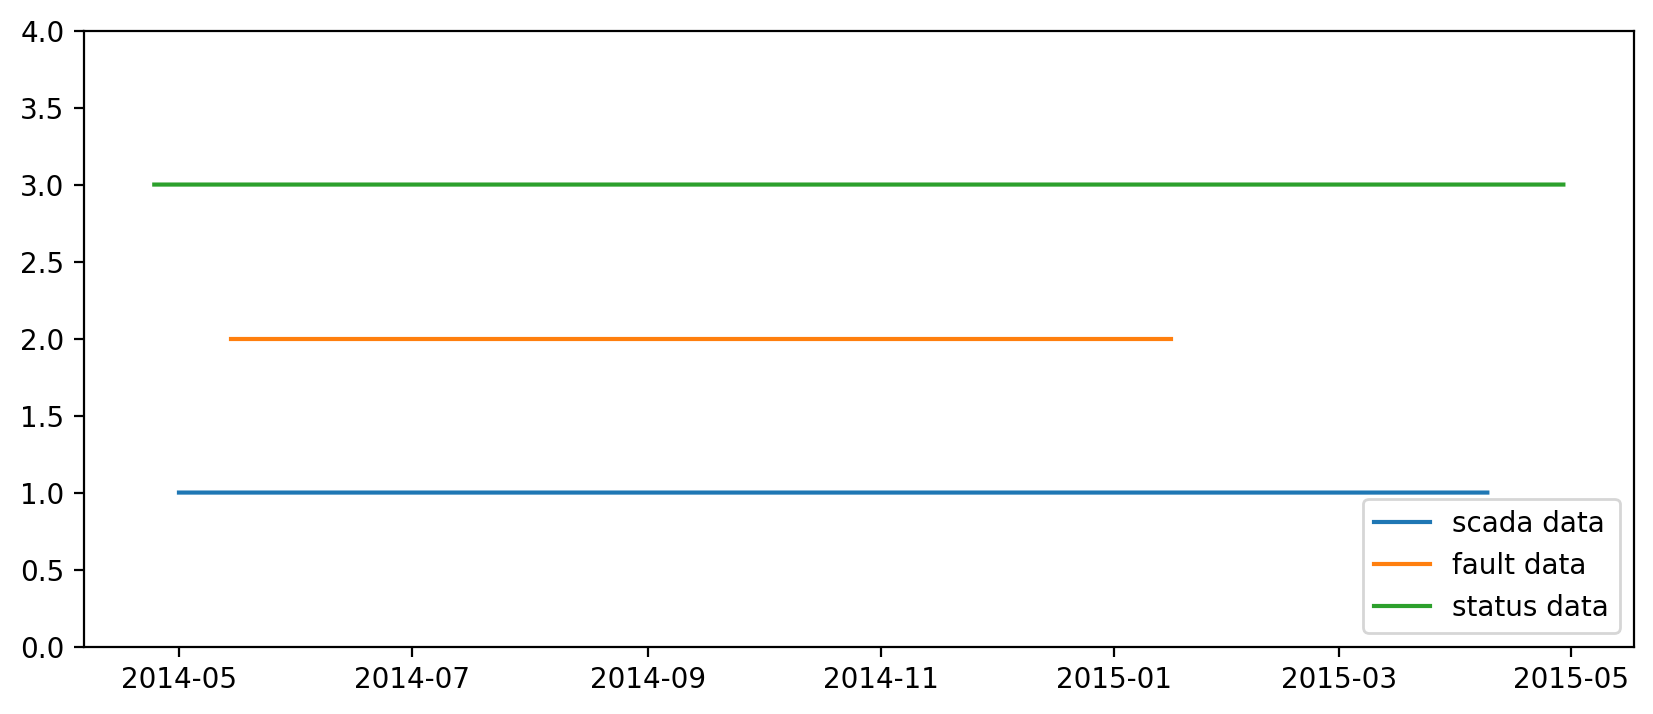

In [8]:
# Plot time span of all data
t_scada = scada_df.DateTime
t_fault = fault_df.DateTime
t_status = status_df.DateTime

plt.figure(figsize=(10,4))
plt.plot(t_scada, np.full(len(scada_df), 1), label='scada data')
plt.plot(t_fault, np.full(len(fault_df), 2), label='fault data')
plt.plot(t_status, np.full(len(status_df), 3), label='status data')
plt.legend(loc='lower right')
plt.ylim(0,4)

<Axes: xlabel='DateTime'>

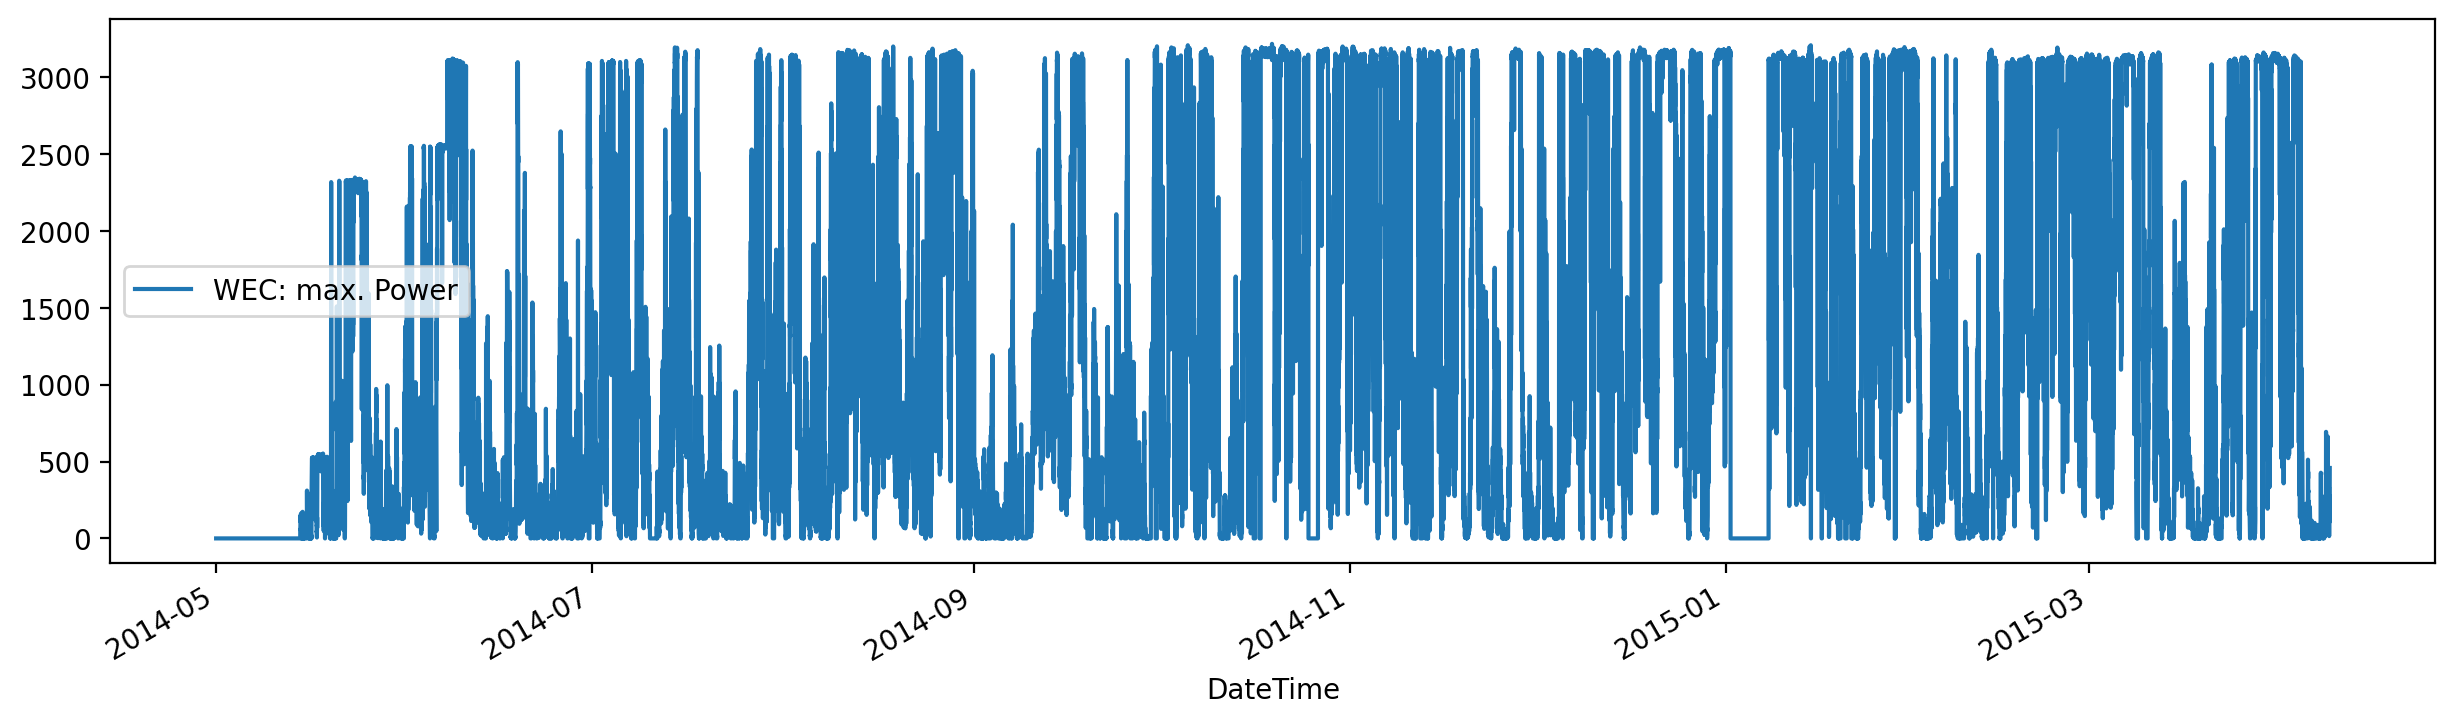

In [9]:
# Plot of max power from SCADA data
scada_df.plot(x='DateTime', y='WEC: max. Power', figsize=(15,4))

<Axes: xlabel='DateTime'>

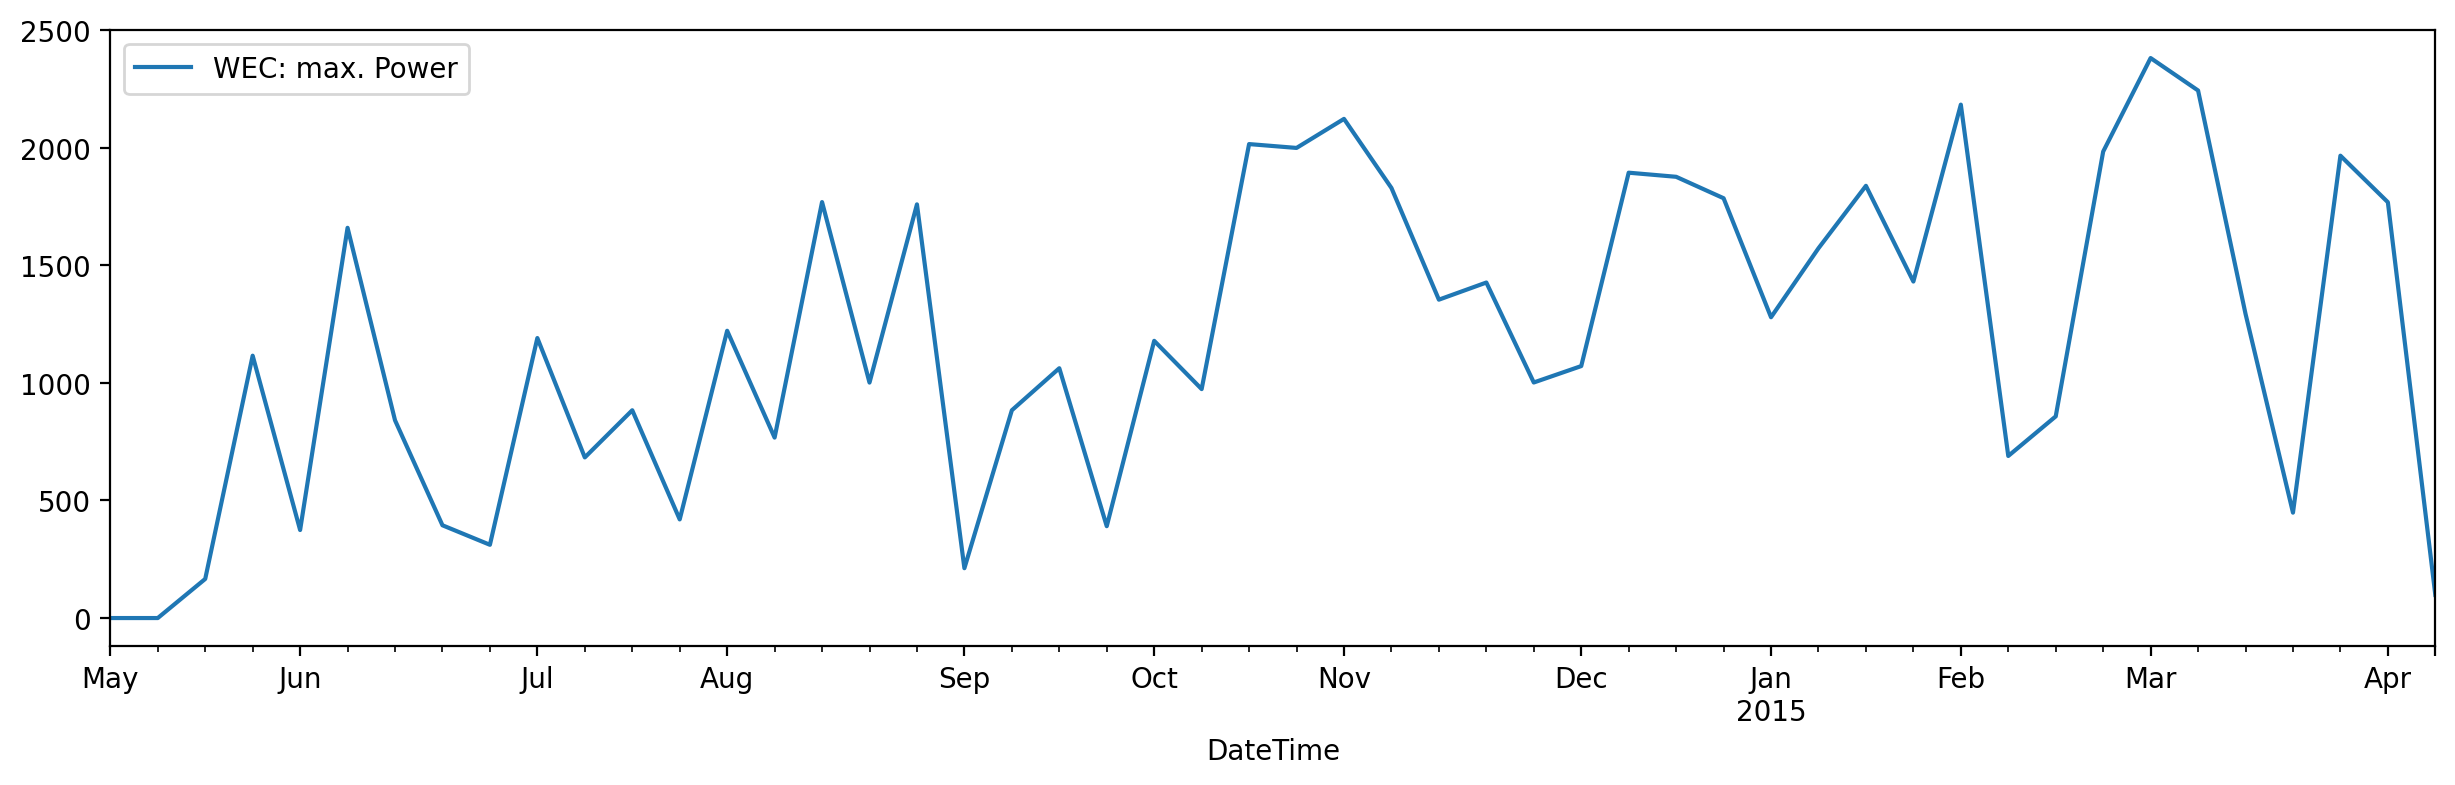

In [10]:
# Plot of max power on weekly resampled data
y = 'WEC: max. Power'
scada_df.resample('W', on='DateTime').mean().plot(y=y, figsize=(15,4))

There were times when power dropped, for example in October 2014, December 2014, and the most significant in January 2015.

<Axes: xlabel='DateTime'>

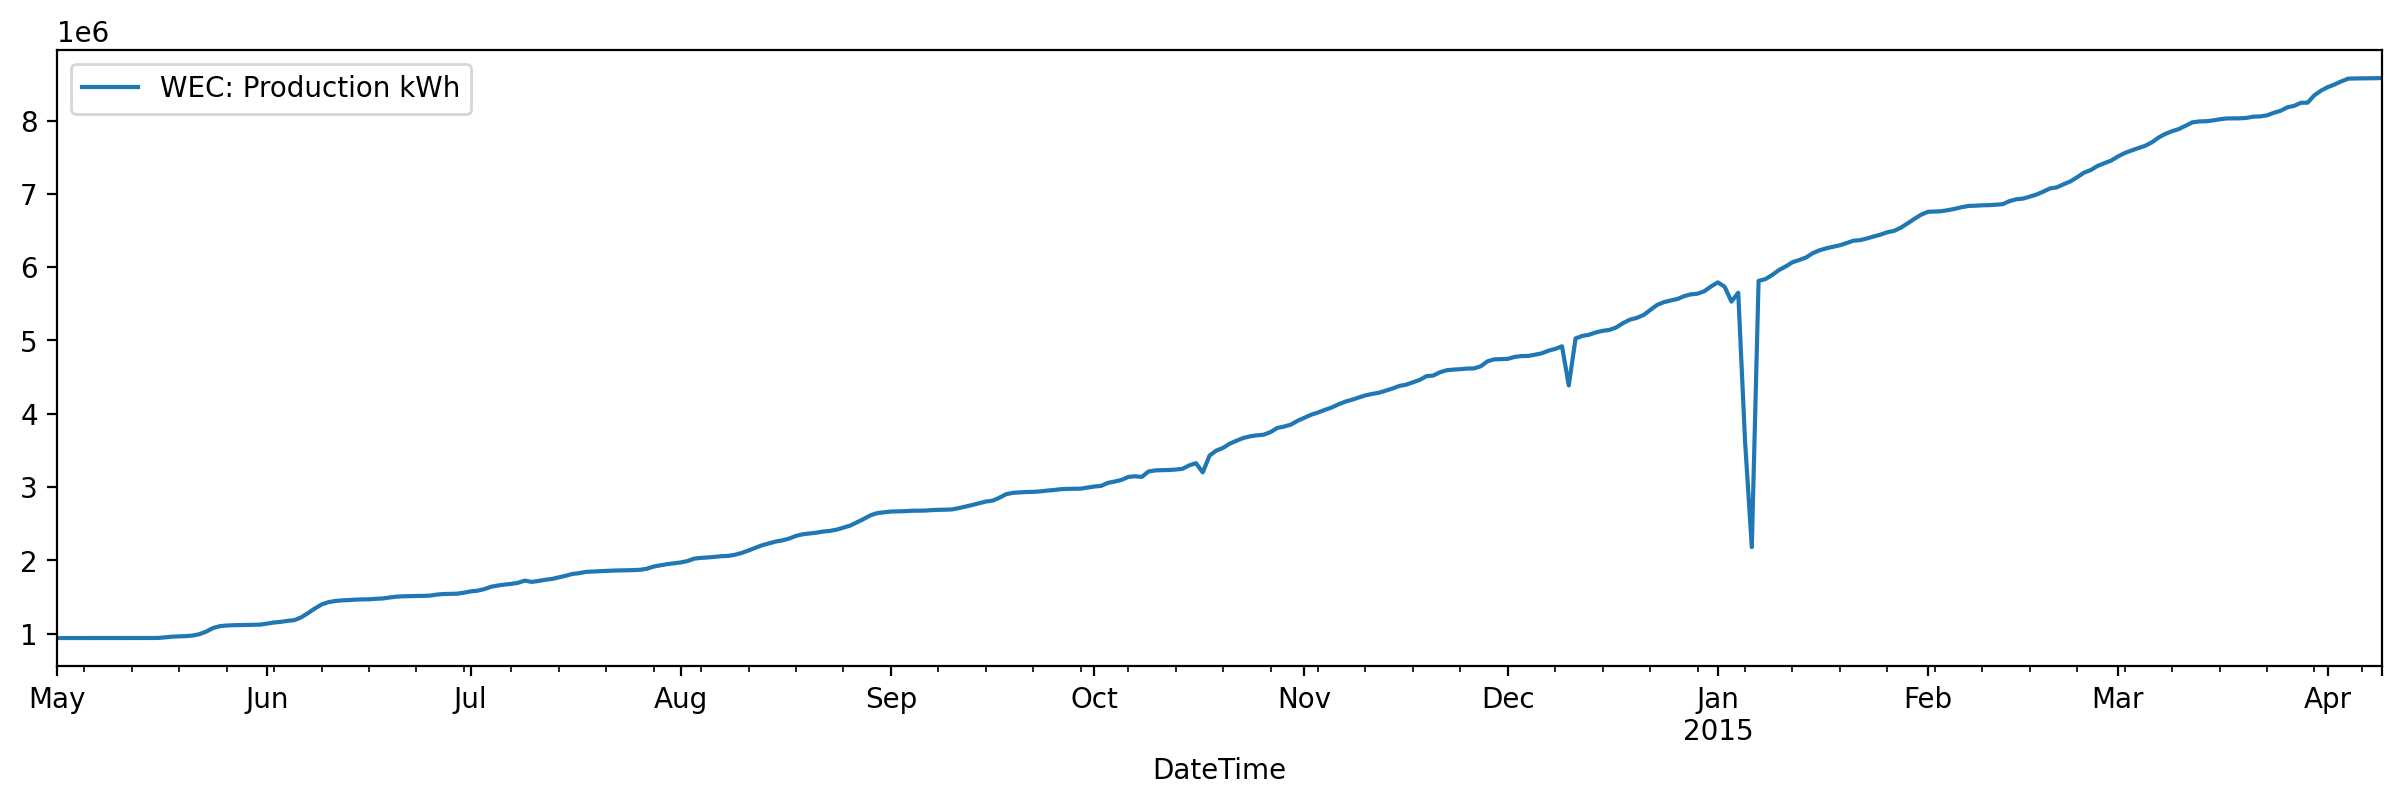

In [11]:
# Plot of power production on monthly resampled data
y = 'WEC: Production kWh'
scada_df.resample('D', on='DateTime').mean().plot(y=y, figsize=(15,4))

The number of wind turbine faults significantly increases on October 2014.

<Axes: xlabel='DateTime'>

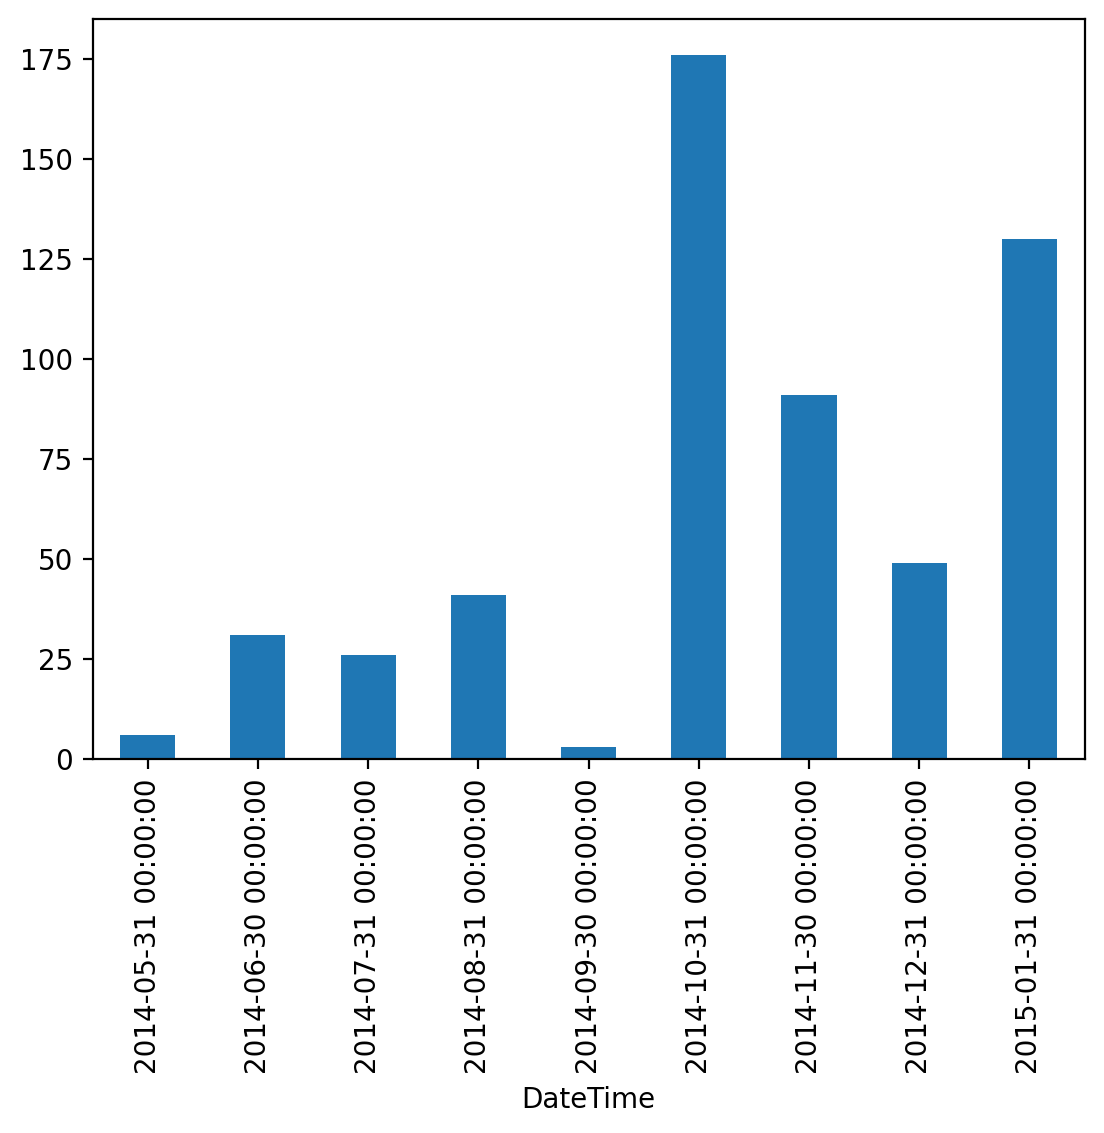

In [12]:
# Plot of number of faults on monthly resampled data
fault_df.resample('ME', on='DateTime').Fault.count().plot.bar()

In [13]:
fault_df.resample('ME', on='DateTime').Fault.value_counts()

DateTime    Fault
2014-05-31  GF        6
2014-06-30  AF       15
            MF       14
            FF        2
2014-07-31  AF       10
            EF        8
            FF        6
            MF        2
2014-08-31  AF       28
            EF        7
            FF        6
2014-09-30  AF        3
2014-10-31  EF       93
            FF       68
            GF       11
            MF        4
2014-11-30  EF       66
            FF       25
2014-12-31  FF       49
2015-01-31  FF       98
            GF       26
            AF        6
Name: count, dtype: int64

Let's plot the faults grouped by its fault modes. There are lots of EF events in October and November 2014, and lots of FF events from October 2014 - January 2015.

In [14]:
def line_format(label):
    """
    Convert time label to the format of pandas line plot
    """
    month = label.month_name()[:3]
    if month == 'Jan':
        month += f'\n{label.year}'
    return month

<Axes: title={'center': 'Wind Turbine Faults'}, xlabel='DateTime', ylabel='Fault Counts'>

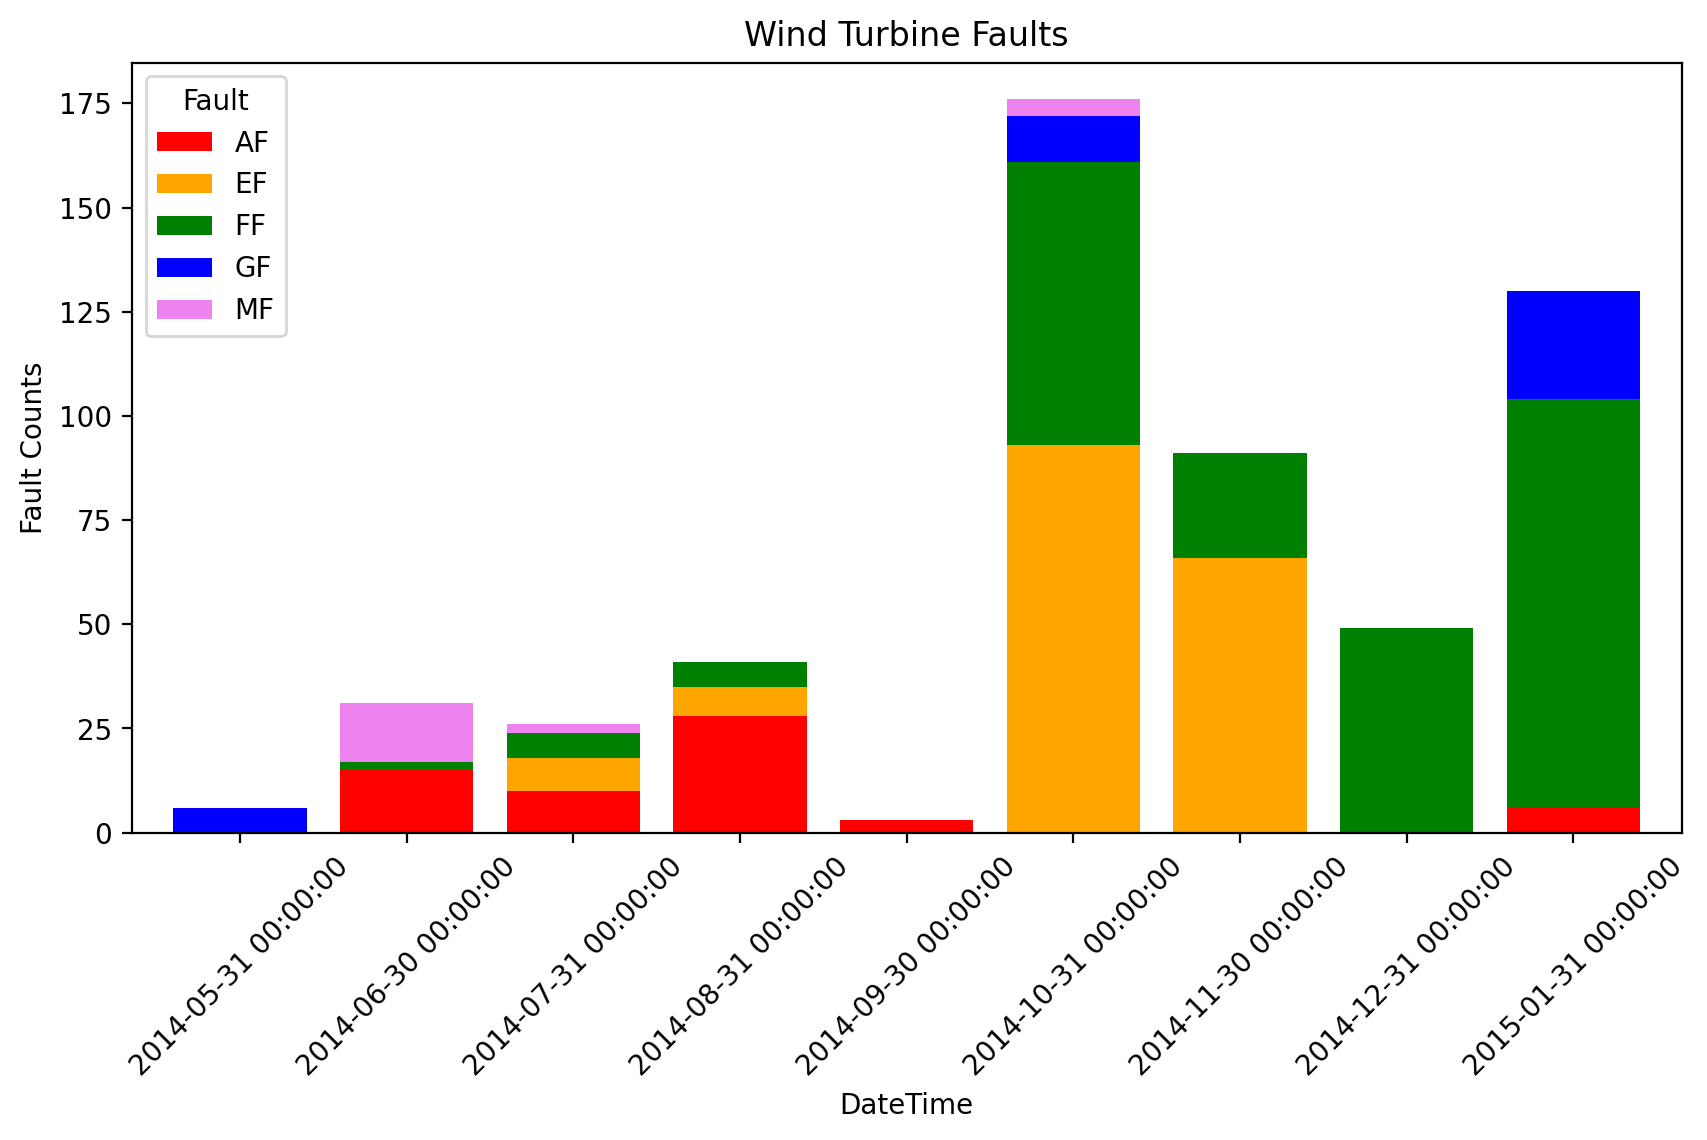

In [15]:
c = ['red', 'orange', 'green', 'blue', 'violet']
fault_df.resample('ME', on='DateTime').Fault.value_counts().unstack().plot.bar(stacked=True, width=0.8, figsize=(10,5), color=c, rot=45,
                                                                              title='Wind Turbine Faults', ylabel='Fault Counts')

# 3. Combine SCADA and faults data

We combine SCADA and fault data to pair each measurements with associated faults.

<Axes: >

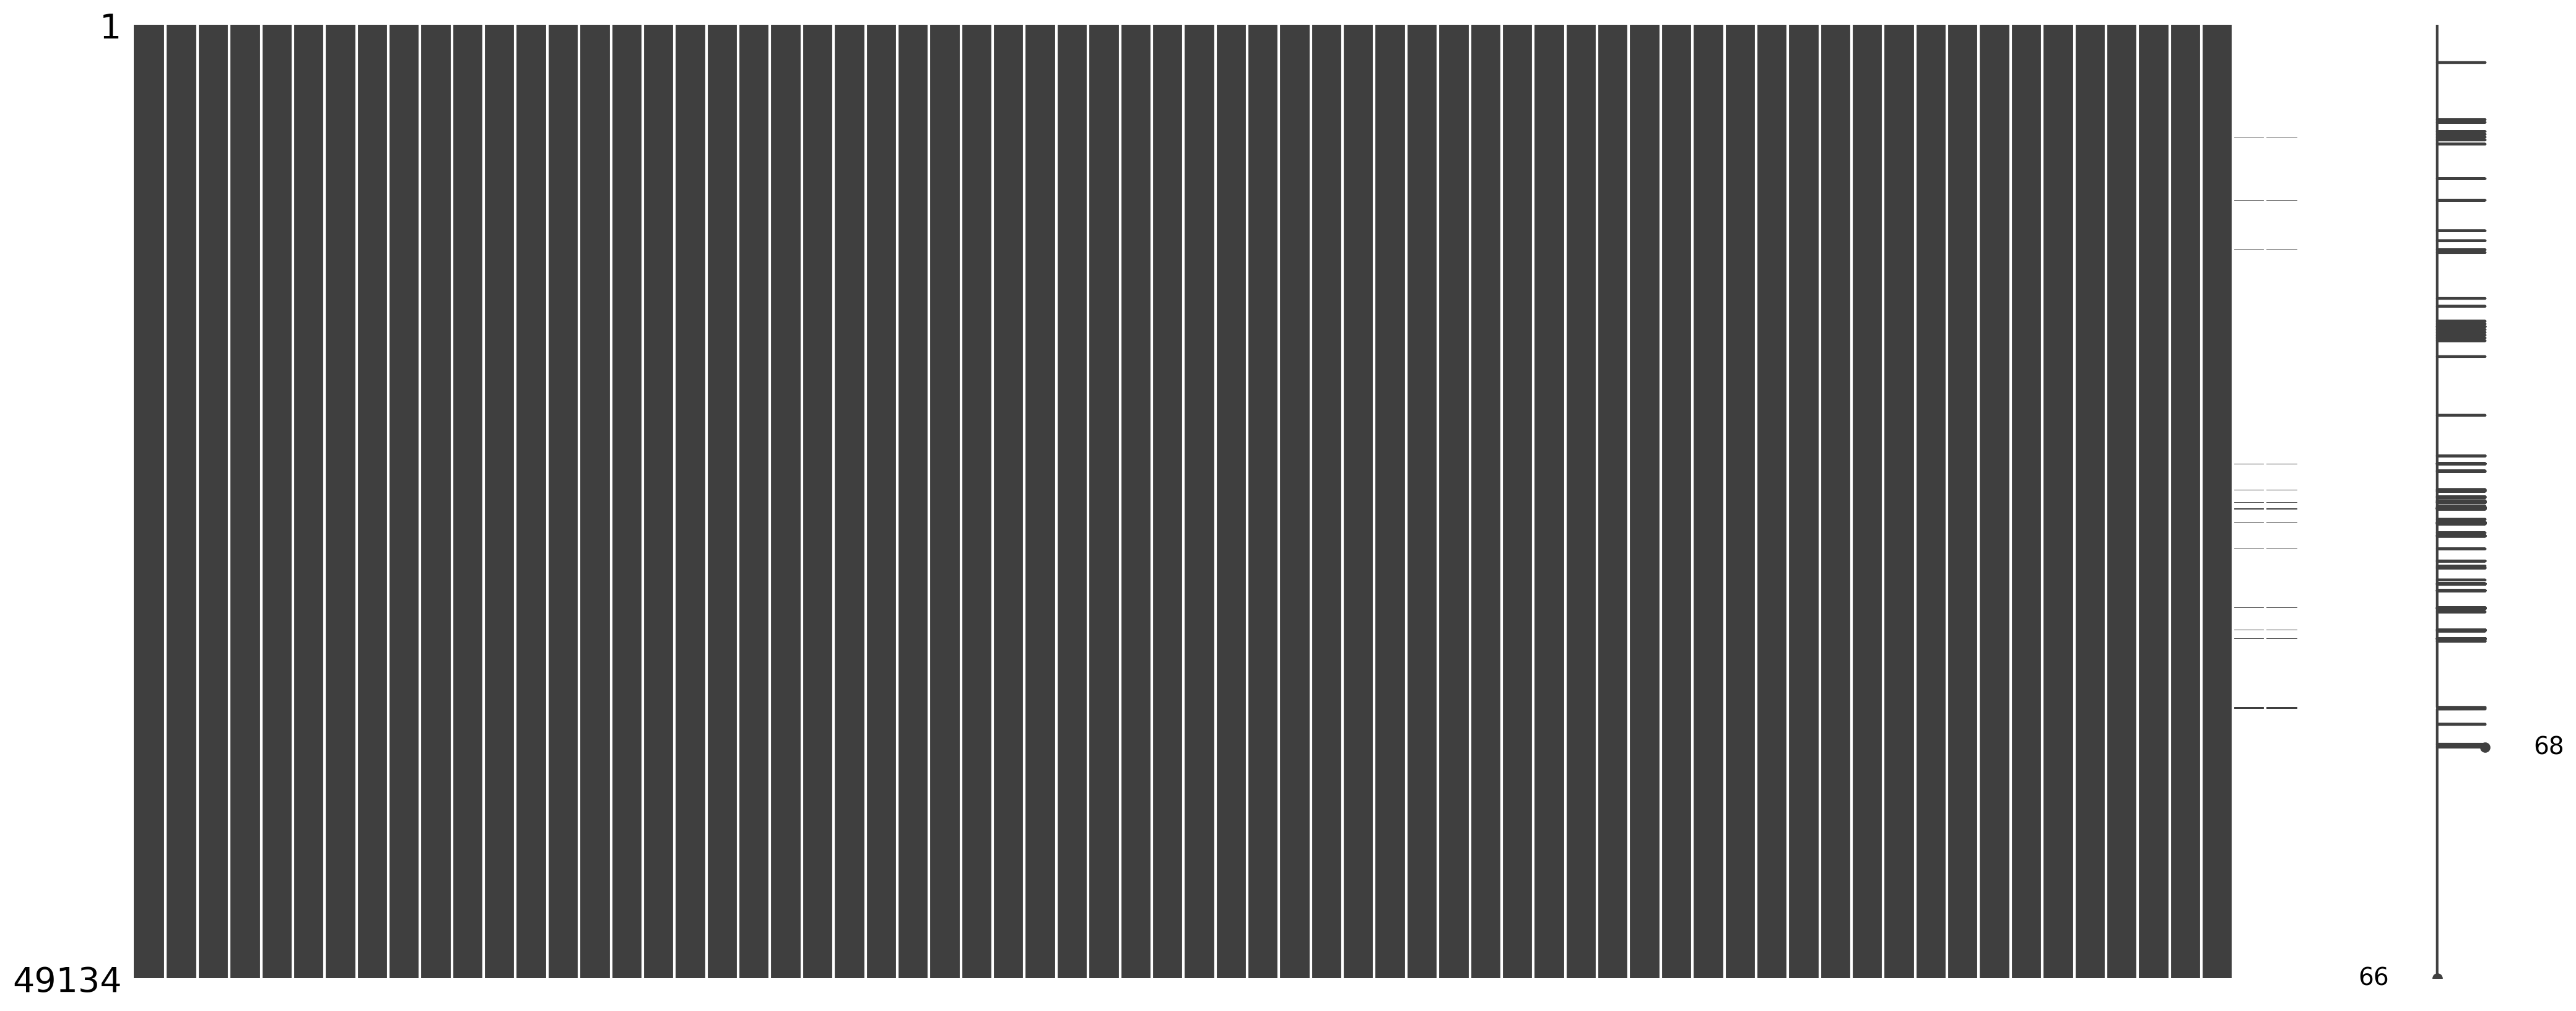

In [16]:
# Combine scada and fault data
df_combine = scada_df.merge(fault_df, on='Time', how='outer')
msno.matrix(df_combine)

There are lots of NaNs, or unmatched SCADA timestamps with fault timestamps, simply because there are no faults happen at certain time. For these NaNs, we will replace with "NF".

**NF is No Fault (normal condition)**

In [17]:
# Replace records that has no fault label (NaN) as 'NF' (no fault)
df_combine['Fault'] = df_combine['Fault'].replace(np.nan, 'NF')

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.00,0.02,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.00,0.01,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.00,0.04,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.00,0.08,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.00,0.05,0.00,0,...,25,12,14,23,34,2501,25.272728,1.103713,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,2015-04-08 23:20:00,1428553216,0,3.9,5.5,2.2,6.75,7.40,6.01,147,...,28,9,17,27,35,3050,24.454546,3.474583,NaT,NF
49130,2015-04-08 23:30:00,1428553856,0,3.9,5.6,2.9,6.64,7.06,6.33,128,...,28,9,17,27,35,3050,24.454546,3.445683,NaT,NF
49131,2015-04-08 23:39:00,1428554368,0,4.2,6.7,2.6,7.18,8.83,6.22,163,...,28,9,18,27,34,3050,24.363636,3.413876,NaT,NF
49132,2015-04-08 23:50:00,1428555008,0,4.1,6.6,2.7,7.02,7.94,6.20,160,...,28,9,17,27,34,3050,24.000000,3.376389,NaT,NF


# 4. Exploratory Data Analysis

Print the averages of SCADA values grouped by fault modes.

In [18]:
# Suppress scientific notations
pd.set_option('display.float_format', lambda x: '%.3f' % x)

# Groupby fault and take average
df_summary = df_combine.groupby('Fault').mean().T
df_summary.tail(20)

Fault,AF,EF,FF,GF,MF,NF
Rotor temp. 1,55.565,100.368,66.071,34.140,52.300,52.517
Rotor temp. 2,55.677,99.920,65.925,34.860,52.500,52.614
Stator temp. 1,68.903,101.592,70.425,42.837,66.350,60.702
Stator temp. 2,68.323,100.454,69.720,42.465,65.850,60.204
Nacelle ambient temp. 1,15.629,14.500,11.016,12.116,14.800,12.515
Nacelle ambient temp. 2,15.629,14.299,10.917,11.930,14.650,12.435
Nacelle temp.,19.290,17.368,14.051,14.093,17.850,16.339
Nacelle cabinet temp.,22.919,20.736,17.831,19.395,21.000,19.852
Main carrier temp.,20.548,19.632,15.866,13.279,19.100,16.551
Rectifier cabinet temp.,32.629,30.385,26.697,30.767,30.000,30.354


Seeing the averages above, we could identify the anomalous behavior of Fault Modes:

* WF has lower ava, min, max active reactive power than No Fault (NF)
* EF has higher ava, min, max active reactive power than No Fault (NF)
* GF has ZERO ava, min, max active reactive power
* FF and MF have higher nacelle cable twisting than NF
* AF and GF have negative nacelle cable twisting
* AF and MF have lower production
* All faults have higher blade angle, the highest is FF
* GF in general has the lowest temperature in ALL components (cabinet temp, T spinner, T front bearing, ..., T transformer)
* While other faults (FF, AF, MF, EF) have higher temperature
* EF temperature is highest in cabinet, pitch, rotor, stator, ambient, control, tower, and transformer
* AF temperature is highest in spinner, front bearing, rare bearing, nacelle, main carrier, rectifier, yaw, and fan inverter

The boxplots of temperatures (at spinner, bearing, nacelle, and fan inverter) shows that during GF, the temperatures are anomalously lower than normal condition. However, temperatures are higher than normal during AF and EF.

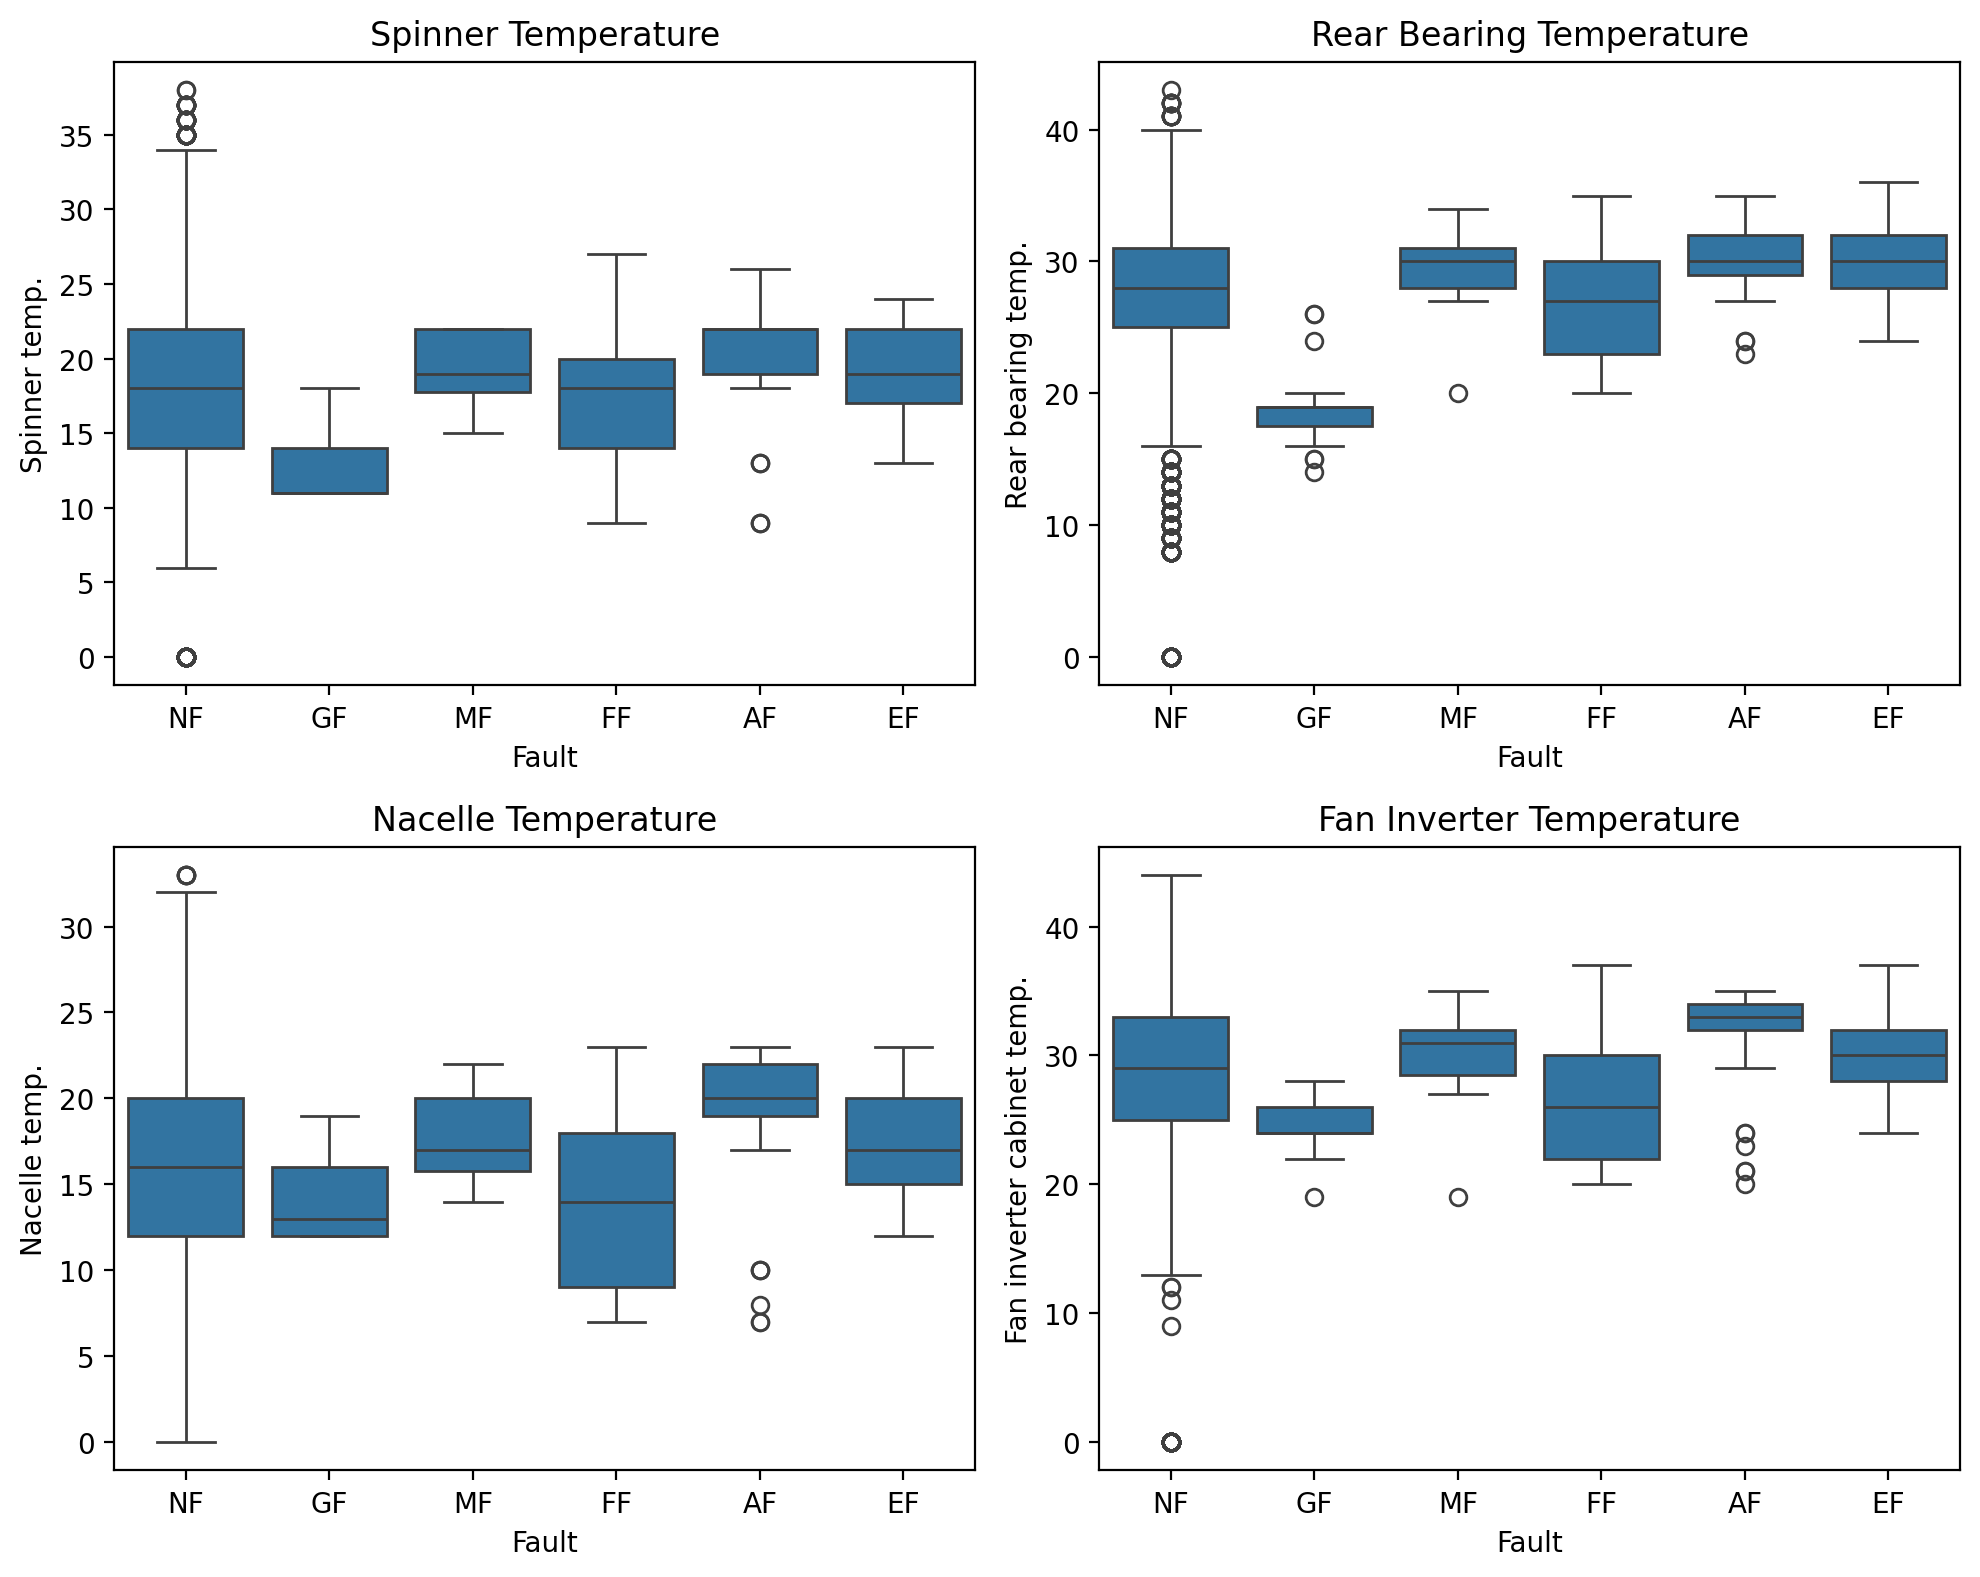

In [19]:
# Boxplots of temperature
f, axes = plt.subplots(nrows=2, ncols=2,figsize=(10,8))

sns.boxplot(x='Fault', y='Spinner temp.', data=df_combine, ax=axes[0][0])
axes[0][0].set_title('Spinner Temperature')
sns.boxplot(x='Fault', y='Rear bearing temp.', data=df_combine, ax=axes[0][1])
axes[0][1].set_title('Rear Bearing Temperature')
sns.boxplot(x='Fault', y='Nacelle temp.', data=df_combine, ax=axes[1][0])
axes[1][0].set_title('Nacelle Temperature')
sns.boxplot(x='Fault', y='Fan inverter cabinet temp.', data=df_combine, ax=axes[1][1])
axes[1][1].set_title('Fan Inverter Temperature')

plt.tight_layout()

Boxplot of reactive power (power from the generator?) shows the power during EF is anomalously high, while the power during MF is lower than normal condition. 

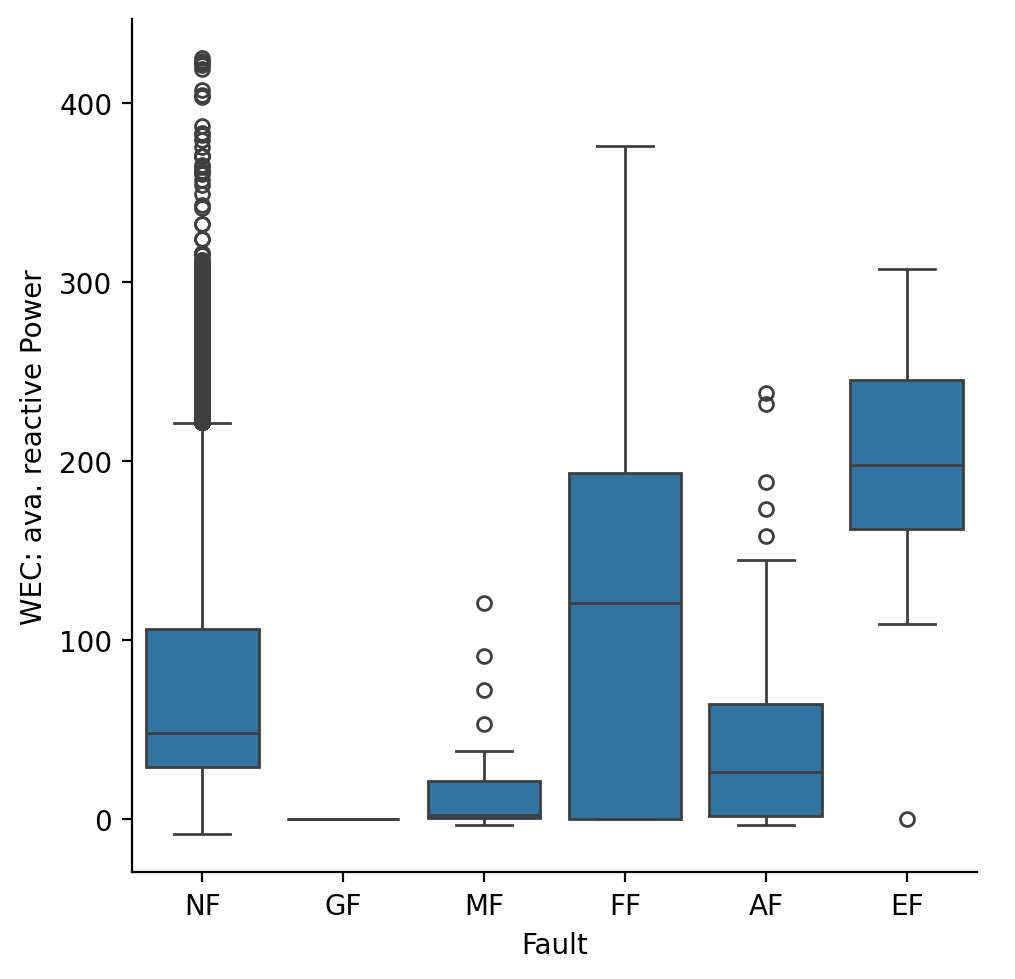

In [20]:
sns.catplot(data=df_combine, x='Fault', y='WEC: ava. reactive Power', kind='box')

The boxplot of nacelle position and cable twisting shows that during AF, nacelle position is negative (up to -500) while during MF, FF, and EF, nacelle position is positive (up to +500).

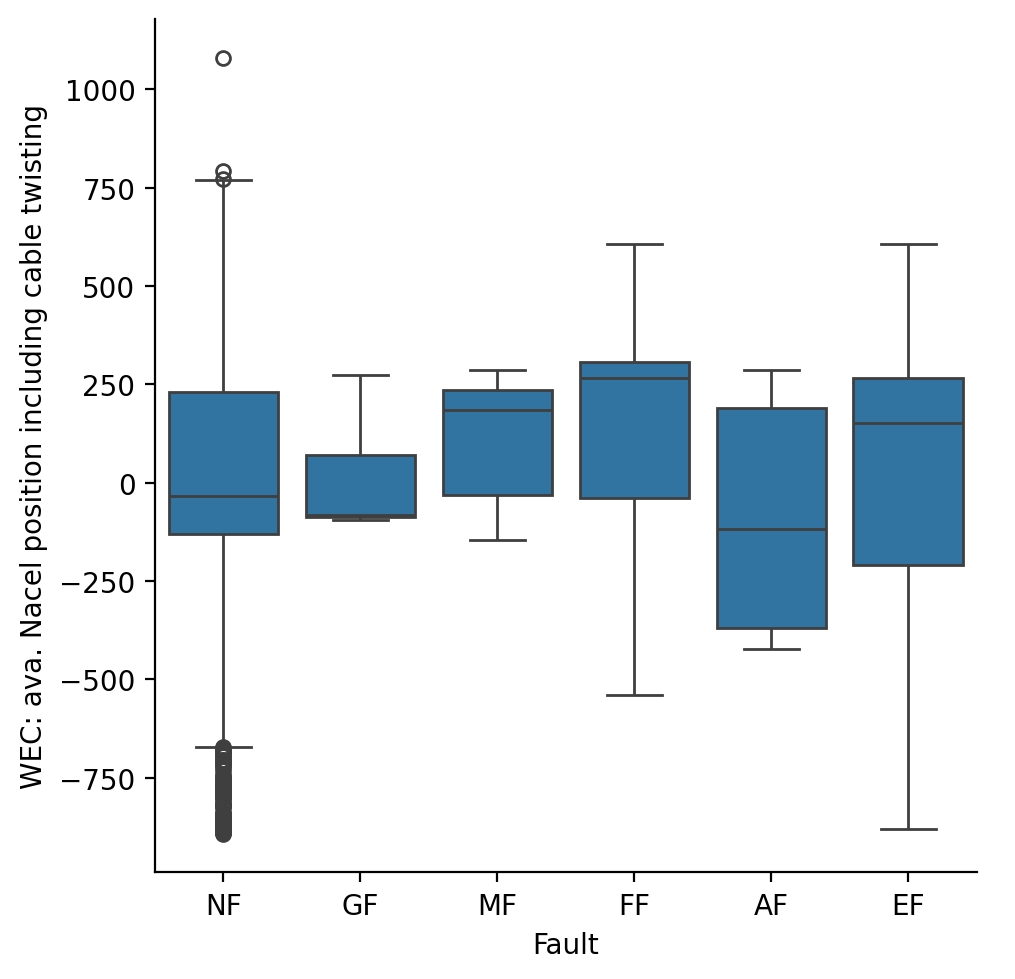

In [21]:
sns.catplot(data=df_combine, x='Fault', y='WEC: ava. Nacel position including cable twisting', kind='box')

The boxplot of operating hours shows that during MF and AF, the operating hours are shorter than normal condition. However, during FF, the operating hours are longer than normally are.

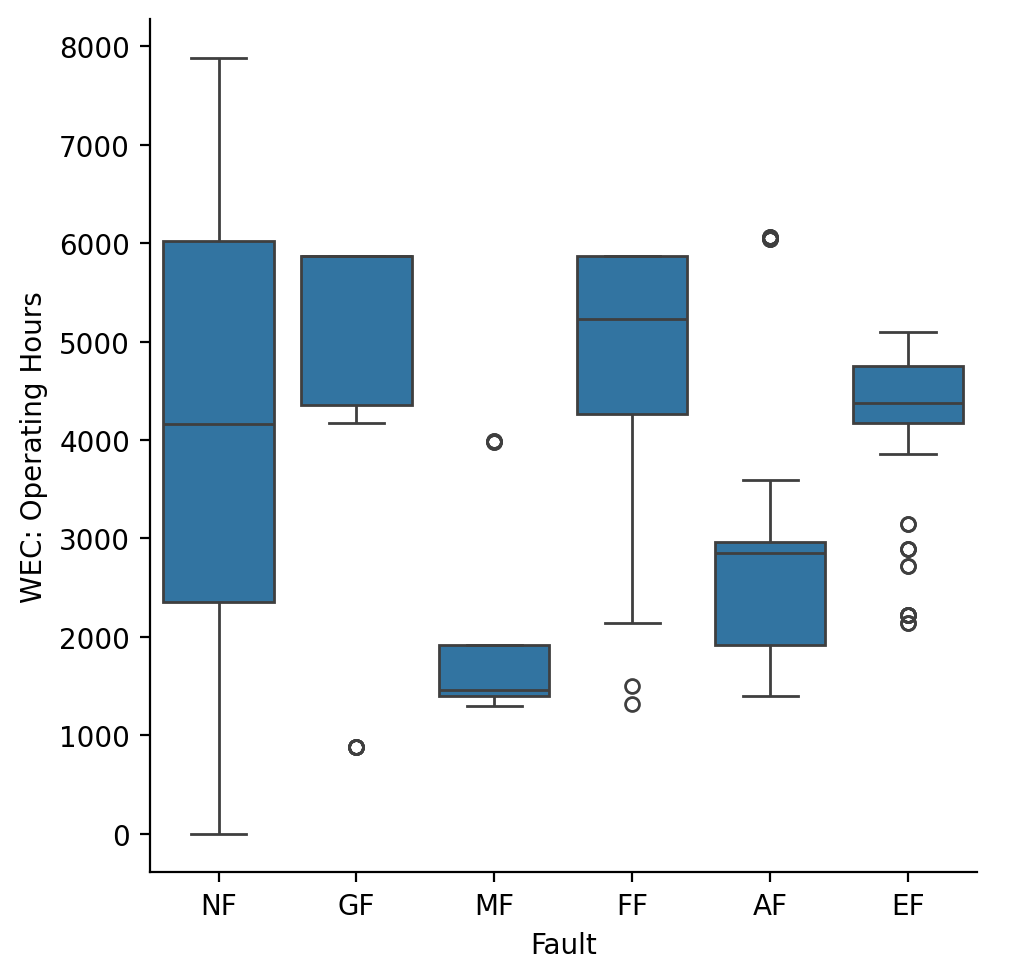

In [22]:
sns.catplot(data=df_combine, x='Fault', y='WEC: Operating Hours', kind='box')

# 5. Data preparation for ML

There are far more records of NF (normal condition) than faulty records - imbalanced dataset. We will sample the No Fault dataframe and pick only 300 records. 

In [23]:
df_combine.Fault.value_counts()

Fault
NF    48581
FF      254
EF      174
AF       62
GF       43
MF       20
Name: count, dtype: int64

In [24]:
# Pick 300 samples of NF (No Fault) mode data
df_nf = df_combine[df_combine.Fault=='NF'].sample(300, random_state=42)

df_nf

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
7340,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
949,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
37369,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
15200,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
42798,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6298,2014-06-14 13:50:00,1402771840,0,2.200,4.300,0.400,4.600,5.120,4.150,1,...,40,24,25,35,45,3050,35.000,1.414,NaT,NF
22374,2014-10-04 01:38:00,1412404736,0,7.100,9.000,5.500,10.120,10.770,9.500,875,...,27,13,26,34,43,3050,28.091,1.136,NaT,NF
39742,2015-02-02 16:41:00,1422916864,0,2.100,2.600,1.700,5.050,5.320,4.940,6,...,21,4,8,17,27,3050,19.909,1.044,NaT,NF
34504,2014-12-28 02:40:00,1419756032,0,7.800,9.500,5.200,10.670,11.720,9.360,1138,...,22,4,19,27,38,3050,19.818,0.603,NaT,NF


In [25]:
# With fault mode data
df_f = df_combine[df_combine.Fault!='NF']

df_f

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
1945,2014-05-14 14:39:00,1400096384,0,5.700,7.400,4.100,9.980,10.230,9.720,0,...,27,17,26,35,34,2501,25.818,0.603,2014-05-14 14:39:44,GF
1946,2014-05-14 14:50:00,1400097024,0,6.400,8.600,2.700,4.120,10.710,0.700,0,...,27,17,26,35,34,2501,26.091,0.944,2014-05-14 14:50:24,GF
1947,2014-05-14 14:58:00,1400097536,0,5.600,7.500,4.000,9.990,10.200,9.800,0,...,27,17,26,35,34,2501,26.455,0.820,2014-05-14 14:58:56,GF
1948,2014-05-14 15:09:00,1400098176,0,5.300,6.600,4.100,9.980,10.170,9.790,0,...,27,18,26,35,34,2501,26.182,0.874,2014-05-14 15:09:36,GF
1949,2014-05-14 15:20:00,1400098816,0,5.100,7.200,3.800,9.990,10.170,9.800,0,...,28,18,26,35,34,2501,26.182,0.982,2014-05-14 15:20:16,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:48,AF
37076,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:20,AF
37218,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:08,AF
37219,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:48,AF


In [26]:
# Combine no fault and faulty dataframes
df_combine = pd.concat((df_nf, df_f), axis=0).reset_index(drop=True)

df_combine

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-06-21 19:29:00,1403396992,0,3.500,4.600,2.400,6.370,6.640,6.160,87,...,40,20,26,36,45,3050,34.273,3.228,NaT,NF
1,2014-05-07 16:39:00,1399498752,0,5.300,15.000,3.000,0.000,0.000,0.000,0,...,26,16,15,24,33,2501,24.455,0.934,NaT,NF
2,2015-01-17 00:00:00,1421474432,0,9.200,10.800,8.100,13.480,13.950,12.920,2078,...,20,3,18,25,40,3050,19.091,1.446,NaT,NF
3,2014-08-15 07:30:00,1408105856,0,7.200,9.600,5.000,10.450,11.620,9.700,998,...,30,21,30,37,48,3050,30.545,1.036,NaT,NF
4,2015-02-23 22:30:00,1424752256,0,14.900,20.900,11.200,14.690,15.540,14.130,3060,...,22,6,28,39,67,3050,28.273,1.902,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,2015-01-14 23:00:00,1421298048,0,13.500,22.000,7.700,14.690,15.190,13.830,2736,...,24,8,29,35,57,3050,25.909,1.814,2015-01-14 23:00:48,AF
849,2015-01-14 23:09:00,1421298560,0,15.500,25.700,1.900,2.530,14.670,0.000,20,...,23,7,22,35,57,3050,28.182,1.834,2015-01-14 23:09:20,AF
850,2015-01-15 22:50:00,1421383808,0,8.400,9.700,6.800,12.790,13.300,11.640,1667,...,21,5,21,28,42,3050,20.909,1.300,2015-01-15 22:50:08,AF
851,2015-01-15 23:00:00,1421384448,0,8.100,9.800,6.000,11.710,13.270,9.990,1311,...,20,5,21,28,42,3050,20.909,1.300,2015-01-15 23:00:48,AF


Preparing for the training dataset, we **drop irrelevant features**. First we drop datetime, time, and error columns. Next, features that "de facto" are output of wind turbine, such as power from wind, operating hours, and kWh production, are dropped. Also, climatic variable such as wind speed are not useful.

In [27]:
# Drop irrelevant features
train_df = df_combine.drop(columns=['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                    'WEC: ava. available P from wind',
                                    'WEC: ava. available P technical reasons',
                                    'WEC: ava. Available P force majeure reasons',
                                    'WEC: ava. Available P force external reasons',
                                    'WEC: max. windspeed', 'WEC: min. windspeed', 
                                    'WEC: Operating Hours', 'WEC: Production kWh',
                                    'WEC: Production minutes', 'DateTime_y'])

train_df

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,6.370,6.640,6.160,87,123,65,171,32,32,32,...,36,40,20,26,36,45,3050,34.273,3.228,NF
1,0.000,0.000,0.000,0,0,0,-52,0,0,0,...,22,26,16,15,24,33,2501,24.455,0.934,NF
2,13.480,13.950,12.920,2078,2533,1696,-66,173,204,152,...,16,20,3,18,25,40,3050,19.091,1.446,NF
3,10.450,11.620,9.700,998,1491,710,-376,64,79,55,...,24,30,21,30,37,48,3050,30.545,1.036,NF
4,14.690,15.540,14.130,3060,3114,2994,-68,296,299,294,...,19,22,6,28,39,67,3050,28.273,1.902,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,14.690,15.190,13.830,2736,2798,2417,-78,238,243,224,...,21,24,8,29,35,57,3050,25.909,1.814,AF
849,2.530,14.670,0.000,20,2746,0,-76,4,241,0,...,21,23,7,22,35,57,3050,28.182,1.834,AF
850,12.790,13.300,11.640,1667,1914,1259,-66,145,170,119,...,17,21,5,21,28,42,3050,20.909,1.300,AF
851,11.710,13.270,9.990,1311,1945,781,-53,111,155,77,...,16,20,5,21,28,42,3050,20.909,1.300,AF


<Axes: title={'center': 'Fault Modes'}, ylabel='count'>

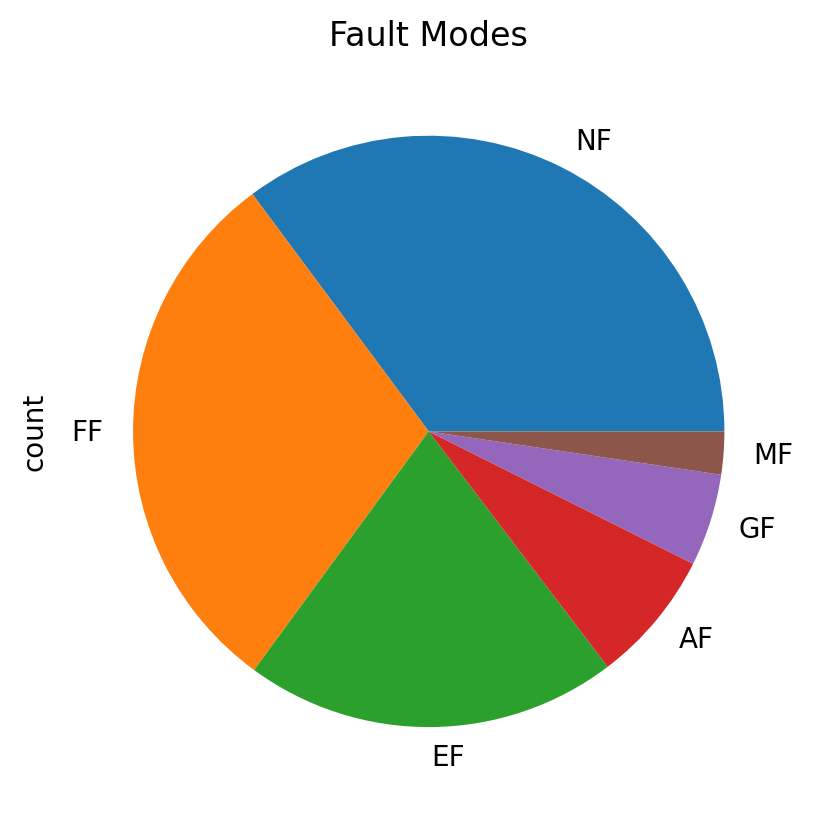

In [28]:
# Imbalanced fault modes
train_df.Fault.value_counts().plot.pie(title='Fault Modes')

# 6. Machine learning - fault modes classification

We are going to build a predictive model to classify fault modes of wind turbine based on the information or status of wind turbine components (gear box, tower, nacelle, bearing, etc.) from SCADA system. This is a multiclass classification task.

## 6.1 Machine learning - LightGBM

Because our training data is largely imbalanced for each fault modes, we use **SMOTE** (Synthetic Minority Oversampling Technique) to oversample the minority classes. The classifier that we use is **LightGBM** (Gradient Boosting Machine). To avoid overfitting, we did **Stratified K-Fold** cross-validation with 5-folds. **Multiple scoring metrics** are used: accuracy, macro-averaged precision, macro recall, and macro F1 score.  

**NOTE.** During cross-validation, the train set will be divided into train set and validation set. Therefore, to ensure that the train set is balanced, the SMOTE should be put inside via **pipeline**. If outside, the score result will be unfair (see this [article](https://towardsdatascience.com/the-right-way-of-using-smote-with-cross-validation-92a8d09d00c7)).

In [ ]:
# Feature and target
# X = df_combine.iloc[:,3:-2]
# y = df_combine.iloc[:,-1]
X = train_df.iloc[:,:-1]
y = train_df.iloc[:,-1]


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Make pipeline of SMOTE, scaling, and classifier
pipe = make_pipeline(SMOTE(), StandardScaler(), LGBMClassifier(random_state=42))

# Define multiple scoring metrics
scoring = {
    'acc': 'accuracy',
    'prec_macro': 'precision_macro',
    'rec_macro': 'recall_macro',
    'f1_macro': 'f1_macro'
}

# Stratified K-Fold 
stratkfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Return a dictionary of all scorings
cv_scores = cross_validate(pipe, X_train, y_train, cv=stratkfold, scoring=scoring)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [45]:
X

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,6.370,6.640,6.160,87,123,65,171,32,32,32,...,39,36,40,20,26,36,45,3050,34.273,3.228
1,0.000,0.000,0.000,0,0,0,-52,0,0,0,...,25,22,26,16,15,24,33,2501,24.455,0.934
2,13.480,13.950,12.920,2078,2533,1696,-66,173,204,152,...,21,16,20,3,18,25,40,3050,19.091,1.446
3,10.450,11.620,9.700,998,1491,710,-376,64,79,55,...,27,24,30,21,30,37,48,3050,30.545,1.036
4,14.690,15.540,14.130,3060,3114,2994,-68,296,299,294,...,23,19,22,6,28,39,67,3050,28.273,1.902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
848,14.690,15.190,13.830,2736,2798,2417,-78,238,243,224,...,27,21,24,8,29,35,57,3050,25.909,1.814
849,2.530,14.670,0.000,20,2746,0,-76,4,241,0,...,27,21,23,7,22,35,57,3050,28.182,1.834
850,12.790,13.300,11.640,1667,1914,1259,-66,145,170,119,...,23,17,21,5,21,28,42,3050,20.909,1.300
851,11.710,13.270,9.990,1311,1945,781,-53,111,155,77,...,23,16,20,5,21,28,42,3050,20.909,1.300


In [30]:
# Print scoring results from dictionary
for metric_name, metric_value in cv_scores.items():
    mean = np.mean(metric_value)
    print(f'{metric_name}: {np.round(metric_value, 4)}, Mean: {np.round(mean, 4)}')

fit_time: [0.4142 0.4133 0.4645 0.4317 0.4676], Mean: 0.4383
score_time: [0.0149 0.0139 0.0133 0.0141 0.0135], Mean: 0.0139
test_acc: [0.7083 0.725  0.6975 0.7227 0.7395], Mean: 0.7186
test_prec_macro: [0.5974 0.6625 0.6867 0.646  0.6991], Mean: 0.6583
test_rec_macro: [0.6164 0.6838 0.6373 0.6037 0.7232], Mean: 0.6529
test_f1_macro: [0.6035 0.6697 0.6568 0.6166 0.7052], Mean: 0.6504


**The precision, recall, and F1 score are 65%.**

In [31]:
# Fit pipeline to train set
pipe.fit(X_train, y_train)

# Predict on test set
y_pred = pipe.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4176
[LightGBM] [Info] Number of data points in the train set: 1284, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


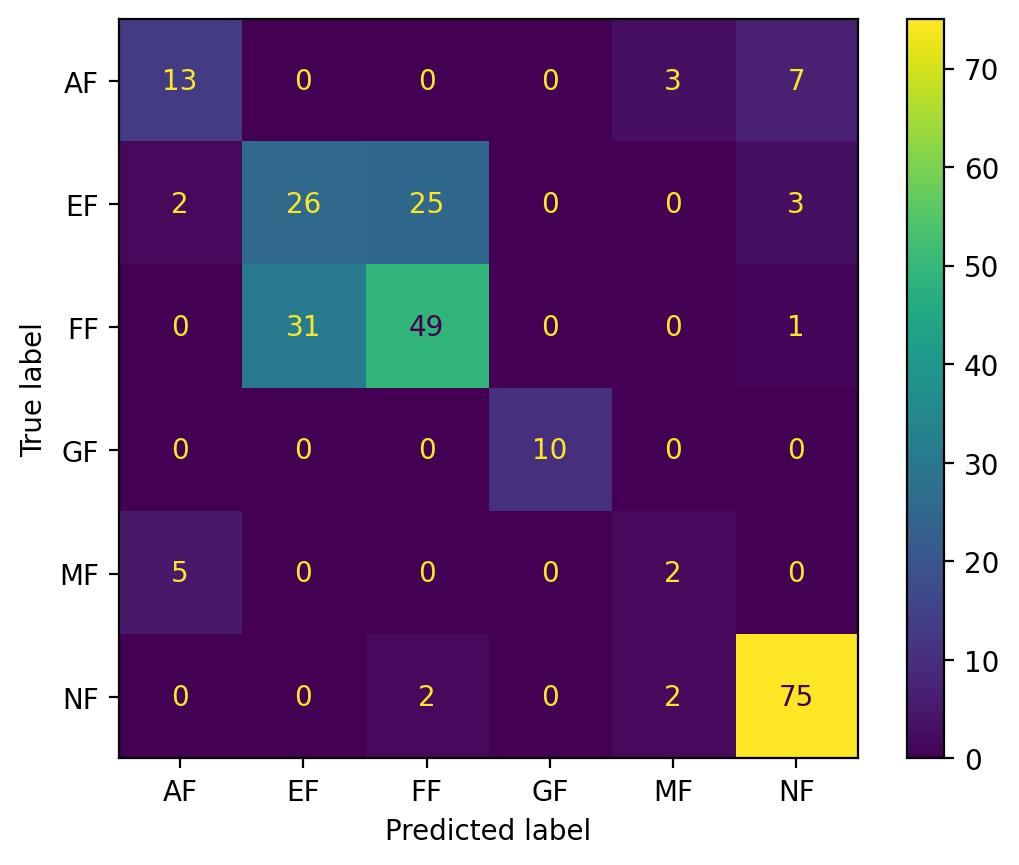

In [32]:
# Confusion matrix of test set
disp = ConfusionMatrixDisplay.from_predictions(y_pred, y_test, values_format='.5g') 
#disp.plot()
plt.show()

We can see 2 problematic (false predicted) classes here are FF and EF. There are 30 EF predicted as FF, and 26 FF predicted as EF.

In [33]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AF       0.57      0.65      0.60        20
          EF       0.46      0.46      0.46        57
          FF       0.60      0.64      0.62        76
          GF       1.00      1.00      1.00        10
          MF       0.29      0.29      0.29         7
          NF       0.95      0.87      0.91        86

    accuracy                           0.68       256
   macro avg       0.64      0.65      0.65       256
weighted avg       0.69      0.68      0.69       256



## 6.2 Hyperparameter tuning for LightGBM

From our previous LightGBM model, we achieved 65% precision, recall, and F1, however we find 2 problematic classes being falsely predicted. We will improve our model with hyperparameter tuning. We will do grid search over **4 hyperparameters** and optimize the **F1 score** as our metric.

In [44]:
# Define parameter search grid
param_grid = {'lgbmclassifier__n_estimators': [16, 24], 
              'lgbmclassifier__num_leaves': [4, 6, 8],
              #'lgbmclassifier__min_data_in_leaf': [20],
              'lgbmclassifier__reg_alpha' : [1, 1.5],
              'lgbmclassifier__reg_lambda': [1, 1.5],
              'lgbmclassifier__boosting_type': ['gbdt'] # Gradient Boosting Decision Tree
             }

# Grid search CV
grid = GridSearchCV(pipe, param_grid, verbose=0, cv=stratkfold, n_jobs=-1, scoring='f1_macro')

# Fit grid on train set
grid.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.263577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4081
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training fro

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.266491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4065
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.246583 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.063544 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4062
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.218558 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4004
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.133077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4052
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.265127 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4023
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000391 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Total Bins 4101
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training fro

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.287971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4067
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.287567 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4016
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.209261 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4039
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.296281 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4044
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.267557 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4096
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4021
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000927 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4027
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.229366 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[Lig

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.283410 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4090
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.302690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4056
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.241376 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4045
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4047
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.045392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4086

[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.136534 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4058
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4035
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.101137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4044
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.215455 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4039
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing row-wise multi-threadi

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4013
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.185518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4042
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.144253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4094
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272546 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4053
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.7

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.274192 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000365 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4043
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326301 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4042
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.155239 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training fro

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000405 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4054
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.245007 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.234360 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4049
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4030
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.327571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4094
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.360867 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4061

[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.175794 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4041
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000403 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4054
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.297104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.279291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4062
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Inf

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277982 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4027
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Inf

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.261289 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4049
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4049
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[Ligh

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4085
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.271587 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4065
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000413 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4020
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.145768 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4046
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.242324 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4032
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Ligh

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.082674 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4091
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.301685 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4054
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4030
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4040
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000454 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4048
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.233568 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4102
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.277781 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4051
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.179280 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4039
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4050
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000384 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4029
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.257611 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4090
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.296932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4043
[LightGBM] [Info] Number of data points in the train set: 1026, 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.226343 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4025
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000515 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4031
[LightGBM] [Info] Number of data points in the train 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.282472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4026
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.272585 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4083
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.318503 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memor

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217646 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4023
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.121979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4042
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4029
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000389 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4029
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000369 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4025
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4034
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.290422 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4106
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4032
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.235926 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4057
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315560 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4031
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.296291 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4086
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training fro

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000497 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4063
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.326667 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4025
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4031
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.285572 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4089
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.281356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4066
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[Lig

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.300146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4022
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4044
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start tr

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.315388 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4045
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Inf

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.294430 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4071
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4053
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Info] Start training from score -1.791759

[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.295971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4019
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.217428 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4054
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.160465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4031
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.253577 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4083
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.7

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.192474 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4043
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.239617 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4034
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[Li

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.186750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4042
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.033501 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4079
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000461 seconds.
You can 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4067
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [W

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4029
[LightGBM] [Info] Number of data points in the train set: 1026, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.255000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.247652 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4038
[LightGBM] [Info] Number of data points in the train set: 1032, number of used features: 50
[LightGBM] [Info] Start training from score -1.791759
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",Pipeline(step...m_state=42))])
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","{'lgbmclassifier__boosting_type': ['gbdt'], 'lgbmclassifier__n_estimators': [16, 24], 'lgbmclassifier__num_leaves': [4, 6, ...], 'lgbmclassifier__reg_alpha': [1, 1.5], ...}"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'f1_macro'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",StratifiedKFo... shuffle=True)
,"verbose verbose: intControls the verbosity: t

We got **improvement to 70% F1-score** with the following tuned hyperparameters.

In [45]:
# Best model from tuning
print(grid.best_params_)
print(f'Average of Macro F1: {grid.best_score_}')

{'lgbmclassifier__boosting_type': 'gbdt', 'lgbmclassifier__n_estimators': 16, 'lgbmclassifier__num_leaves': 4, 'lgbmclassifier__reg_alpha': 1.5, 'lgbmclassifier__reg_lambda': 1.5}
Average of Macro F1: 0.6916668820680016


Using the tuned LightGBM model, we had successfully reduced the false classes i.e. from 30 to only 8 EF classes falsely predicted as FF. 

/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


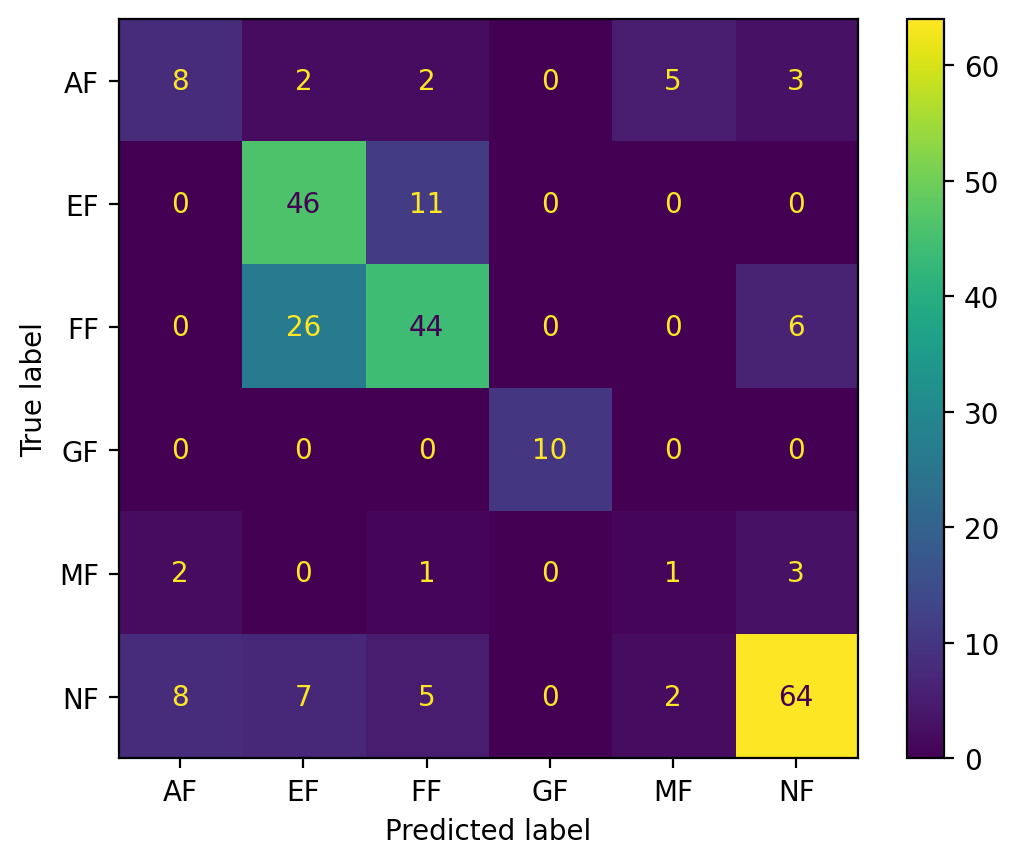

In [46]:
# Confusion matrix of test set
ConfusionMatrixDisplay.from_estimator(grid, X_test, y_test, values_format='.5g') 
plt.show()

Comparing the present classification report to the previous report, we improved the F1-score of EF class from 46% to 69%, and small improvement of FF class from 62% to 68%.  

In [47]:
# Classification report
y_pred = grid.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AF       0.44      0.40      0.42        20
          EF       0.57      0.81      0.67        57
          FF       0.70      0.58      0.63        76
          GF       1.00      1.00      1.00        10
          MF       0.12      0.14      0.13         7
          NF       0.84      0.74      0.79        86

    accuracy                           0.68       256
   macro avg       0.61      0.61      0.61       256
weighted avg       0.69      0.68      0.68       256



/home/luca/.local/lib/python3.12/site-packages/sklearn/utils/validation.py:2691: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


With this improvement, however, there remains some issues recommended for **future improvements of this work**:
* Eventhough there is improvement, 26 FF class still falsely predicted as EF
* Score of MF and AF are very low: 13% and 41%

## 6.3 Machine learning - StandardRandomForest

Let's now test a different model based on Random Forest using [SMOTE again](https://medium.com/sfu-cspmp/surviving-in-a-random-forest-with-imbalanced-datasets-b98b963d52eb)


In [36]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import f1_score, make_scorer, precision_score, recall_score, accuracy_score
#Use SMOTE to oversample the minority class
oversample = SMOTE()
over_X, over_y = oversample.fit_resample(X, y)
over_X_train, over_X_test, over_y_train, over_y_test = train_test_split(over_X, over_y, test_size=0.3, stratify=over_y)
#Build SMOTE SRF model
SMOTE_SRF = RandomForestClassifier(n_estimators=150, random_state=42)
#Create Stratified K-fold cross validation
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=42)
#scoring = (f1_scorer, 'recall', 'precision', 'accuracy')
scoring = {
    'precision': make_scorer(precision_score, average='macro', pos_label=None),
    'recall': make_scorer(recall_score, average='macro'),
    'f1': make_scorer(f1_score, average='macro'),
    'accuracy': make_scorer(accuracy_score)
}
#Evaluate SMOTE SRF model
scores = cross_validate(SMOTE_SRF, over_X, over_y, scoring=scoring, cv=cv)
#Get average evaluation metrics
#print('Mean f1: %.3f' % mean(scores['test_f1']))
#print('Mean recall: %.3f' % mean(scores['test_recall']))
#print('Mean precision: %.3f' % mean(scores['test_precision']))

#Randomly spilt dataset to test and train set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
#Train SMOTE SRF
SMOTE_SRF.fit(over_X_train, over_y_train)
#SMOTE SRF prediction result
y_pred = SMOTE_SRF.predict(X_test)
#X_test

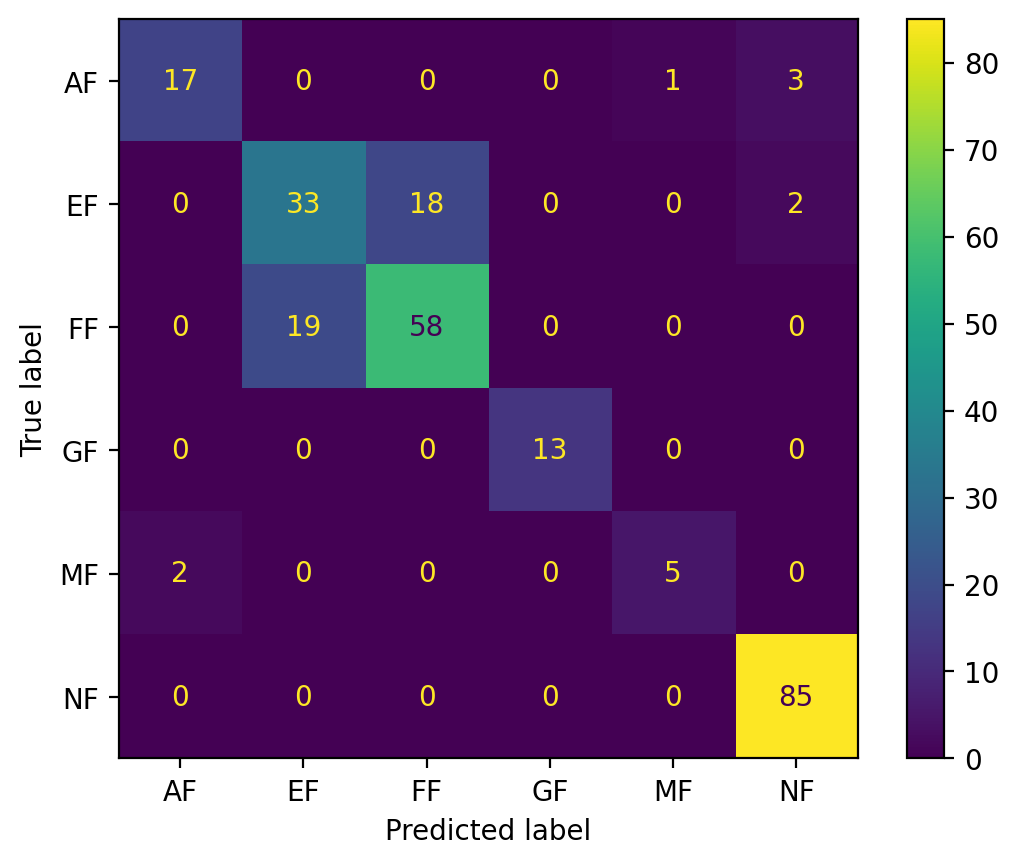

In [39]:
# Confusion matrix of test set
disp = ConfusionMatrixDisplay.from_predictions(y_pred, y_test, values_format='.5g') 
#disp.plot()
plt.show()

We can observe the RandomForest model is way better than the LightGBM, let's print the classification report

In [40]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

          AF       0.81      0.89      0.85        19
          EF       0.62      0.63      0.63        52
          FF       0.75      0.76      0.76        76
          GF       1.00      1.00      1.00        13
          MF       0.71      0.83      0.77         6
          NF       1.00      0.94      0.97        90

    accuracy                           0.82       256
   macro avg       0.82      0.85      0.83       256
weighted avg       0.83      0.82      0.83       256



We have now a **86% F1-score** with the trained SRF model.
We can also see the Features in order of importance in the classification model

<Axes: >

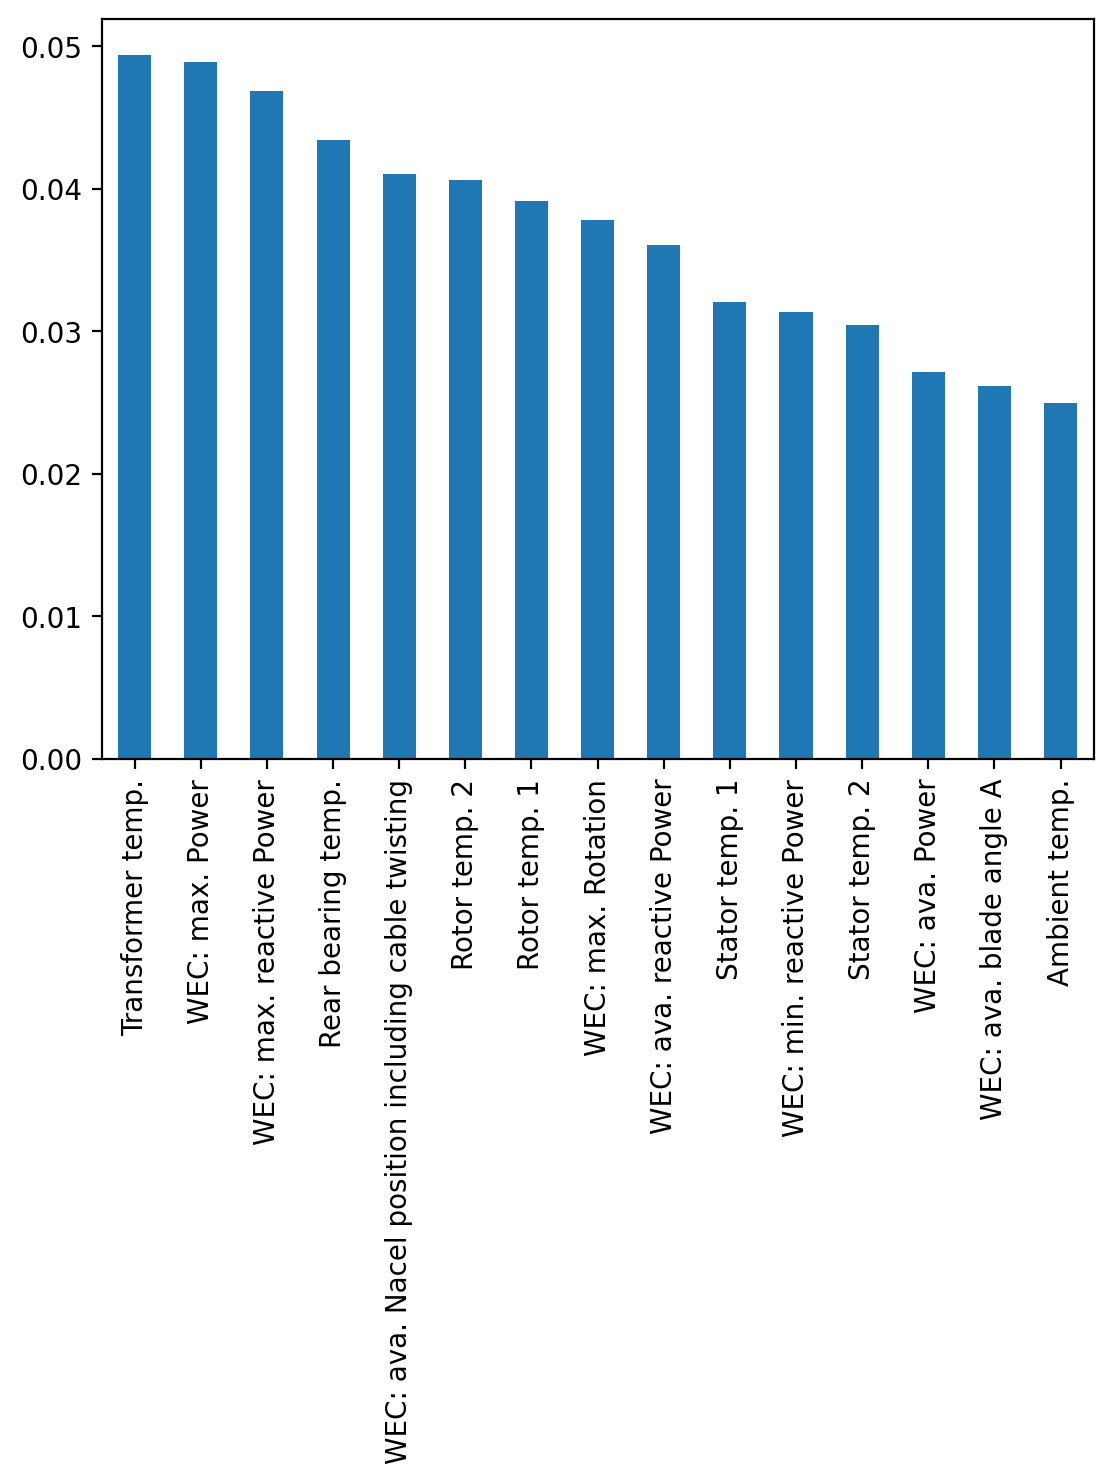

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data (showing only the first 15 featrures)
importances = pd.Series(SMOTE_SRF.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False)[:15].plot.bar()


# 7. Extract and convert model  
We are now ready to extract the trained model and convert it to ONNX format for reuse

In [46]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
# Define the input type for the ONNX model
# We need to tell it the shape (batch size, num_features) and type (float)
n_features = train_df.shape[1]-1  # Subtract 1 for the target column
#logging.info(f"ONNX model will have {n_features} input features.")
initial_type = [('float_input', FloatTensorType([None, n_features]))]
        
# Convert the model
onnx_model = convert_sklearn(SMOTE_SRF, initial_types=initial_type, target_opset={'':15,'ai.onnx.ml': 3})
MODEL_OUTPUT_PATH = "/home/luca/RH26/train_model/srf.onnx"
# Save the model
with open(MODEL_OUTPUT_PATH, "wb") as f:
    f.write(onnx_model.SerializeToString())
            
#logging.info(f"Model successfully saved to {MODEL_OUTPUT_PATH}")


# 8. Conclusion

We analyzed data that comes from the Supervisory Control and Data Acquisition (SCADA) system of a wind turbine from April 2014 until April 2015, with the associated faults that occured during the operating times. The SCADA system gives more than 60 records of all components of the wind turbine such as nacelle, inverter, bearing, and so on. There were 5 fault modes that developed, labeled as FF, AF, EF, MF, and GF. We found out that the number of faults significantly increases in October 2014. 

During faulty times, there are anomalous behaviors of the wind turbine components. For example, during GF, the temperatures of all wind turbine components are lower than during normal conditions. However, temperatures during AF and EF are higher than normal. And then, the reactive power is anomalously high during EF, while power is lower during MF. Therefore, we could classify fault modes based on various SCADA measured components. 

We made an Adaptive Boosting (AdaBoost) based predictive model to classify fault modes. The data is largely imbalanced among fault modes, therefore SMOTE was implemented within a 5-fold CV pipeline. From that attempt, we achieved a macro F1 score of 64-65%. Two problematic classes, EF and FF, were falsely predicted. To correct this and improve the model performance, we performed hyperparameter tuning to tune 4 AdaBoost hyperparameters. After tuning, the macro F1 score improved to 69-70%. The number of false prediction of EF classes successfully reduces. 

The individual F1 scores of AF and MF were still low. Therefore, an improvement of this work is recommended and will be appreciated.

**Thank you!**